# Segregación de notas de un archivo de audio

El siguiente notebook tiene como objetivo demostrar que es posible segregar en multiples ficheros de audio una grabación musical para detectar diferentes acordes.

Para ello utilizaremos la libreria de **librosa** de python intentando detectar segmentos utilizando silencios y cambios de pitch


## 1. Importar helper functions
Empezaremos importando una libreria propia en python con helper functions : https://github.com/lferrerraventos/SoundToTabs/blob/main/notebooks/helpers/helper_functions.py

In [1]:
!wget https://raw.githubusercontent.com/lferrerraventos/SoundToTabs/main/notebooks/helpers/helper_functions.py

--2024-04-22 15:31:25--  https://raw.githubusercontent.com/lferrerraventos/SoundToTabs/main/notebooks/helpers/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6051 (5.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   5.91K  --.-KB/s    in 0s      

2024-04-22 15:31:25 (38.1 MB/s) - ‘helper_functions.py’ saved [6051/6051]



In [20]:
from helper_functions import  create_spectrogram, unzip_data

## 2. Descargar audio

Descargamos una corta grabación que contiene arpegios y acordes

In [4]:
!wget https://github.com/lferrerraventos/SoundToTabs/raw/main/notebooks/datasets/shortguitarsong.mp3

--2024-04-22 16:04:00--  https://github.com/lferrerraventos/SoundToTabs/raw/main/notebooks/datasets/shortguitarsong.mp3
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lferrerraventos/SoundToTabs/main/notebooks/datasets/shortguitarsong.mp3 [following]
--2024-04-22 16:04:00--  https://raw.githubusercontent.com/lferrerraventos/SoundToTabs/main/notebooks/datasets/shortguitarsong.mp3
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 399569 (390K) [audio/mpeg]
Saving to: ‘shortguitarsong.mp3’

shortguitarsong.mp3 100%[===================>] 390.20K  --.-KB/s    in 0.03s   

2024-04-22 16:04:01 (10.9 MB/

In [5]:
from IPython.display import Audio, display
song_path = "shortguitarsong.mp3"

display(Audio(song_path))

## 2. Segmentación de fichero de audio con librosa

In [17]:
!rm -rf segmentos/*
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import os

min_duration = 0.1  # duración mínima en segundos
min_rms = 0.01  # mínimo RMS para considerar un segmento no silencioso

output_folder = "segmentos/"
y, sr = librosa.load(song_path)



# Detectar segmentos usando silencios
non_mute_sections = librosa.effects.split(y, top_db=35)

# Detectar onsets
onsets = librosa.onset.onset_detect(y=y, sr=sr, units='samples', delta=0.02, post_avg=3, pre_avg=3)

# Combina onsets y segmentos no mudos
all_changes = sorted(set(onsets.tolist() + [item for sublist in non_mute_sections for item in sublist]))

# Crear segmentos finales
refined_segments = []
last_pos = all_changes[0]
for change in all_changes[1:]:
    if (change - last_pos) > sr * min_duration:  # Asegurarse de que el segmento tenga una duración mínima
        refined_segments.append((last_pos, change))
        last_pos = change

# Filtrar segmentos por energía
refined_segments = [(start, end) for start, end in refined_segments if librosa.feature.rms(y=y[start:end]).max() > min_rms]

# Crear y guardar espectrogramas para cada segmento refinado
file_paths = []
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for i, (start, end) in enumerate(refined_segments):
    segment_save_path = os.path.join(output_folder, f'segment_{i}.png')
    segment_audio_path = os.path.join(output_folder, f'segment_{i}.wav')
    segment_data = y[start:end]
    if np.any(segment_data):
        sf.write(segment_audio_path, segment_data, sr)
        create_spectrogram(segment_audio_path, segment_save_path)
        file_paths.append(segment_save_path)

print(file_paths)




['segmentos/segment_0.png', 'segmentos/segment_1.png', 'segmentos/segment_2.png', 'segmentos/segment_3.png', 'segmentos/segment_4.png', 'segmentos/segment_5.png', 'segmentos/segment_6.png', 'segmentos/segment_7.png', 'segmentos/segment_8.png', 'segmentos/segment_9.png', 'segmentos/segment_10.png', 'segmentos/segment_11.png', 'segmentos/segment_12.png', 'segmentos/segment_13.png', 'segmentos/segment_14.png', 'segmentos/segment_15.png']


## 3. Visualizar y escuchar segmentos

Reproduciendo: segmentos/segment_0.wav


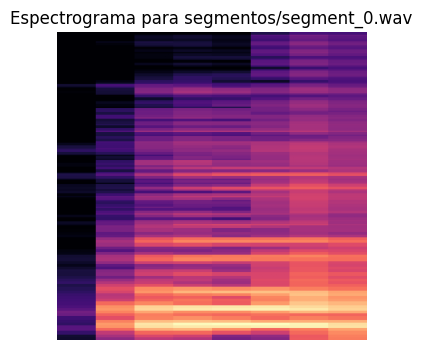

Reproduciendo: segmentos/segment_1.wav


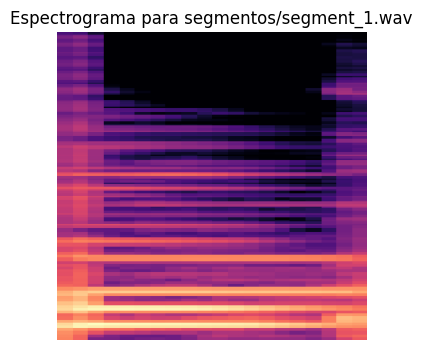

Reproduciendo: segmentos/segment_2.wav


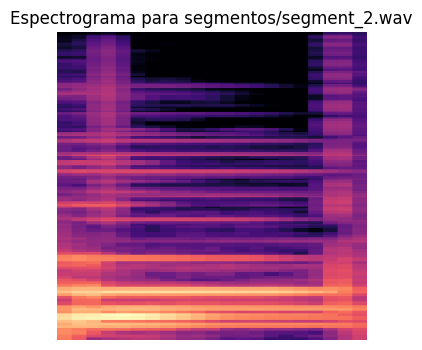

Reproduciendo: segmentos/segment_3.wav


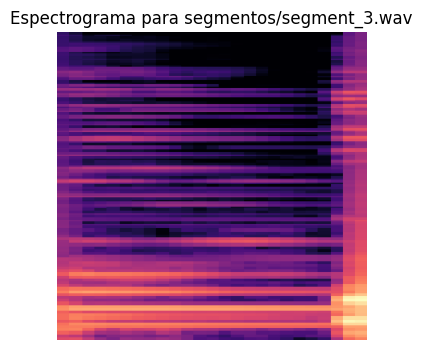

Reproduciendo: segmentos/segment_4.wav


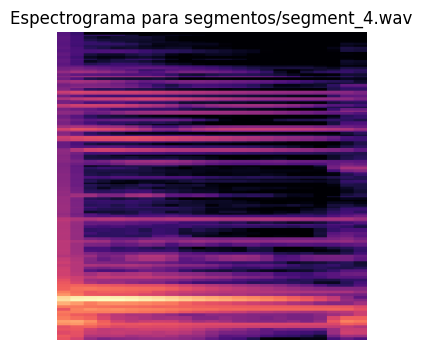

Reproduciendo: segmentos/segment_5.wav


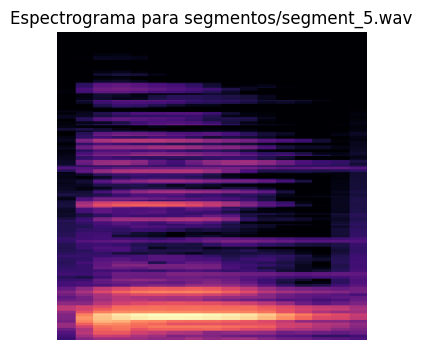

Reproduciendo: segmentos/segment_6.wav


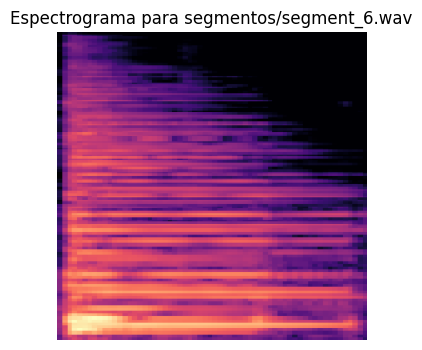

Reproduciendo: segmentos/segment_7.wav


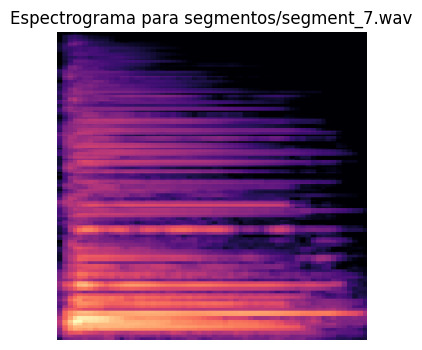

Reproduciendo: segmentos/segment_8.wav


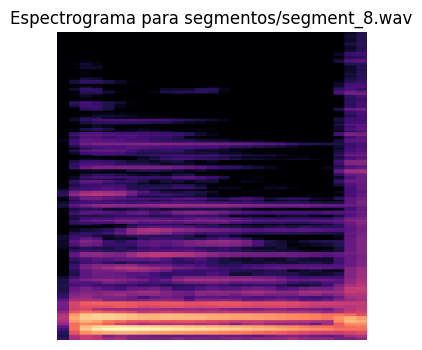

Reproduciendo: segmentos/segment_9.wav


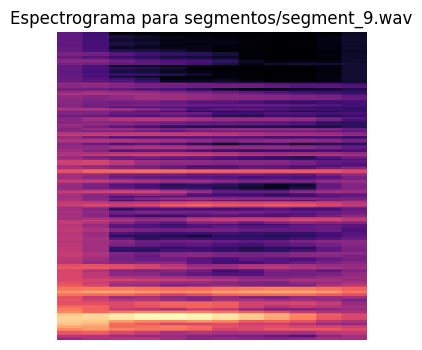

Reproduciendo: segmentos/segment_10.wav


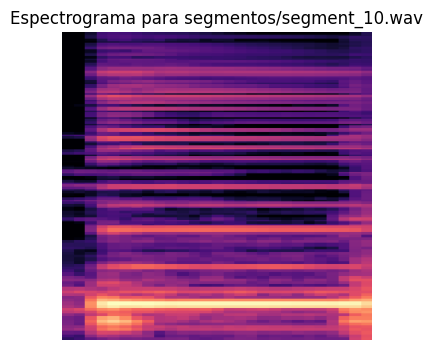

Reproduciendo: segmentos/segment_11.wav


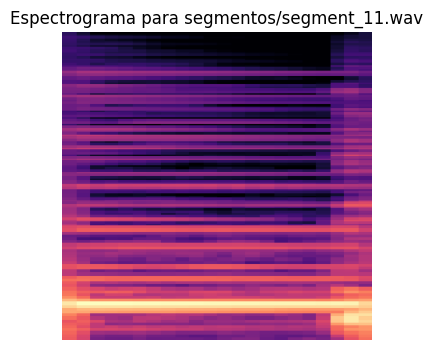

Reproduciendo: segmentos/segment_12.wav


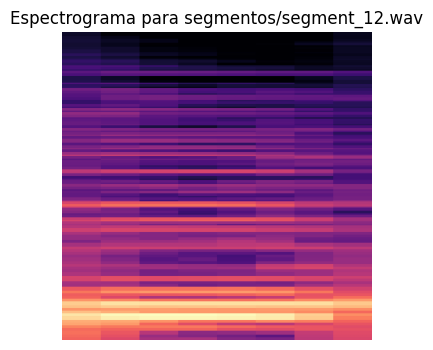

Reproduciendo: segmentos/segment_13.wav


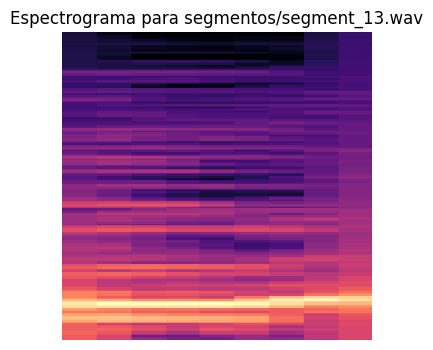

Reproduciendo: segmentos/segment_14.wav


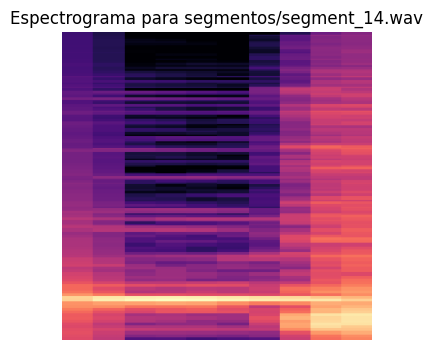

Reproduciendo: segmentos/segment_15.wav


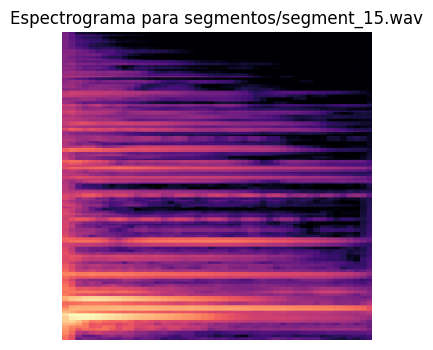

In [25]:
import matplotlib.pyplot as plt
for spectrogram_path in file_paths:
  file_path = spectrogram_path.replace('.png', '.wav')
  # Cargar el espectrograma como una imagen
  img = plt.imread(spectrogram_path)

  # Mostrar el archivo de audio
  print("Reproduciendo:", file_path)
  display(Audio(file_path))

  # Mostrar el espectrograma
  plt.figure(figsize=(10, 4))
  plt.imshow(img)
  plt.title(f'Espectrograma para {file_path}')
  plt.axis('off')  # Omitir los ejes para un aspecto más limpio
  plt.show()

# 4. Descargar modelos de TensorFlow
En este paso descargaremos los modelos previamente instalados para utilizarlos con los diferentes segmentos

In [23]:
import gdown
url = 'https://drive.google.com/uc?id=1QsAhzKn9kERBkjWmwzMhJ5vzi8c8mJni'
output = 'TensorFlowModels.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1QsAhzKn9kERBkjWmwzMhJ5vzi8c8mJni
From (redirected): https://drive.google.com/uc?id=1QsAhzKn9kERBkjWmwzMhJ5vzi8c8mJni&confirm=t&uuid=6aeb9d95-0998-4a96-85ed-11938937bb29
To: /content/TensorFlowModels.zip
100%|██████████| 343M/343M [00:03<00:00, 93.4MB/s]


'TensorFlowModels.zip'

In [24]:
unzip_data("TensorFlowModels.zip")

1/1 [==============================] - 0s 121ms/step


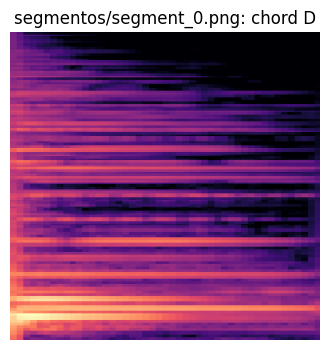

1/1 [==============================] - 0s 118ms/step


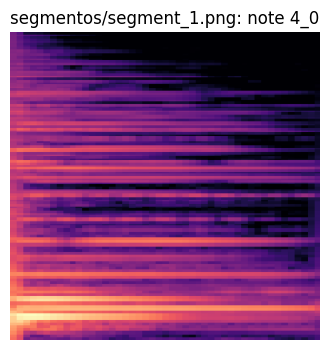

1/1 [==============================] - 0s 116ms/step


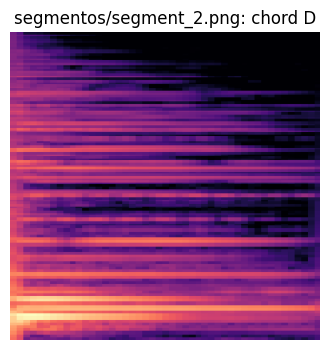

1/1 [==============================] - 0s 184ms/step


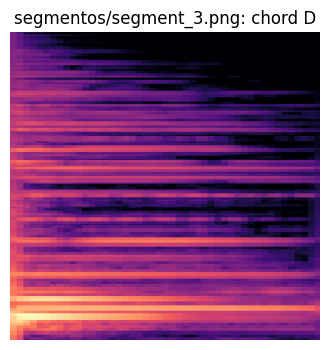

1/1 [==============================] - 0s 113ms/step


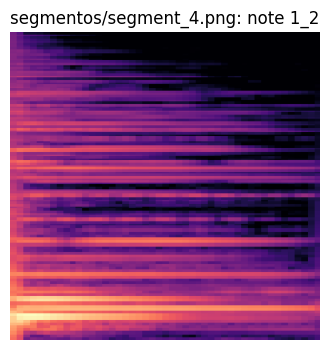

1/1 [==============================] - 0s 120ms/step


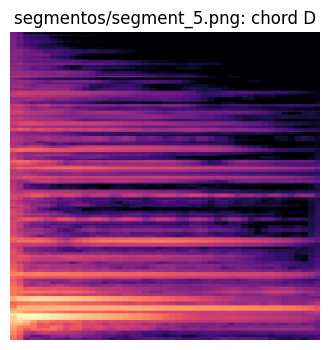

1/1 [==============================] - 0s 122ms/step


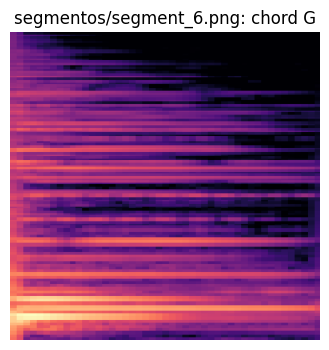

1/1 [==============================] - 0s 116ms/step


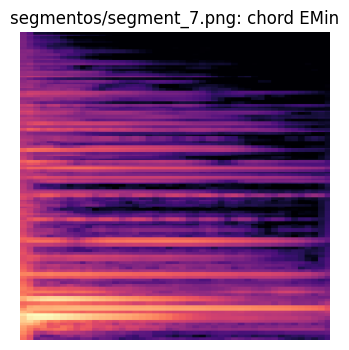

1/1 [==============================] - 0s 178ms/step


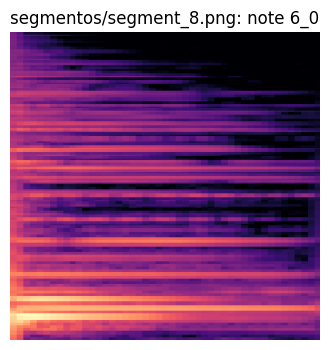

1/1 [==============================] - 0s 113ms/step


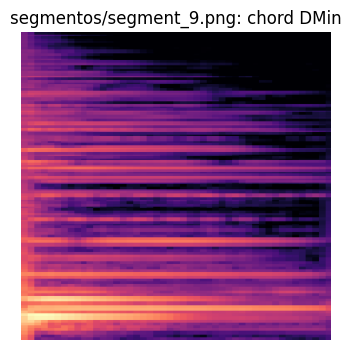

1/1 [==============================] - 0s 109ms/step


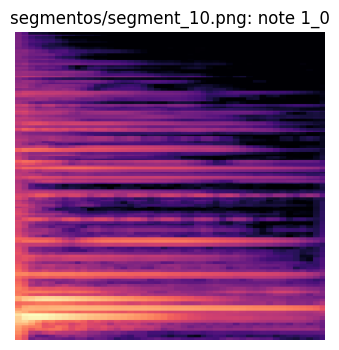

1/1 [==============================] - 0s 111ms/step


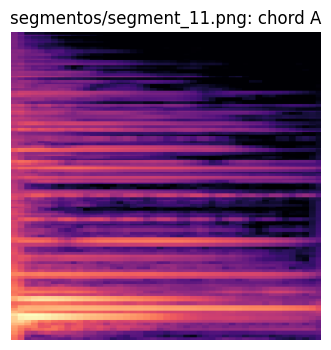

1/1 [==============================] - 0s 116ms/step


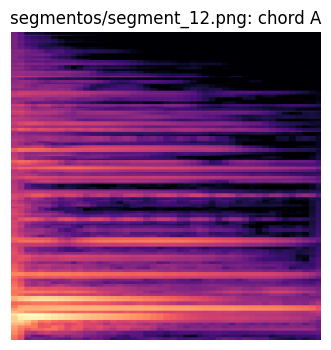

1/1 [==============================] - 0s 161ms/step


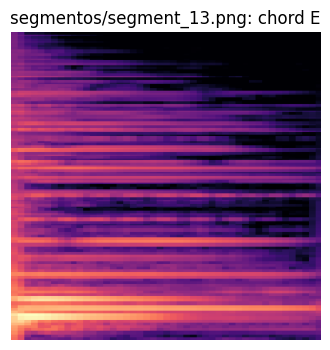

1/1 [==============================] - 0s 115ms/step


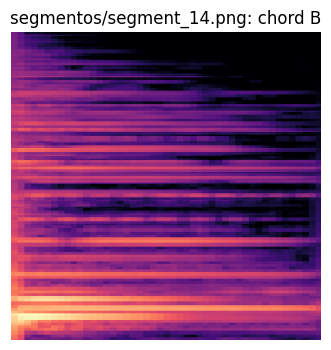

1/1 [==============================] - 0s 120ms/step


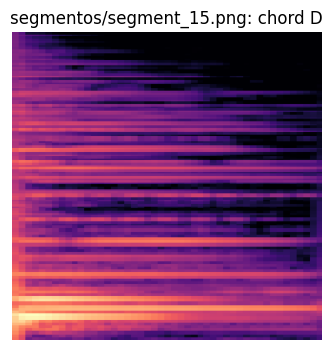

In [37]:
import tensorflow as tf
from keras.preprocessing import image
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

notes_classes = {'1_0': 0,
 '1_1': 1,
 '1_2': 2,
 '1_3': 3,
 '2_0': 4,
 '2_1': 5,
 '2_2': 6,
 '2_3': 7,
 '3_0': 8,
 '3_1': 9,
 '3_2': 10,
 '3_3': 11,
 '4_0': 12,
 '4_1': 13,
 '4_2': 14,
 '4_3': 15,
 '5_0': 16,
 '5_1': 17,
 '5_2': 18,
 '5_3': 19,
 '6_0': 20,
 '6_1': 21,
 '6_2': 22,
 '6_3': 23}

index_to_notes = {v: k for k, v in notes_classes.items()}

chords_classes = {'A': 0,
 'AMin': 1,
 'B': 2,
 'BMin': 3,
 'C': 4,
 'D': 5,
 'DMin': 6,
 'E': 7,
 'EMin': 8,
 'F': 9,
 'G': 10}

index_to_chords = {v: k for k, v in chords_classes.items()}

def load_spectogram_image(path):
    target_size=(224, 224)
    img = image.load_img(path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

def predict_chord_or_note(model_path, spectrogram):
    # Load the binary model to classify between chord and note
    chordvsnote_model = tf.keras.models.load_model(model_path + "chordvsnote.h5")


    # Predict if it's a chord or a note
    prediction = chordvsnote_model.predict(load_spectogram_image(spectrogram))
    is_chord = prediction[0][0] < 0.5

    if is_chord:
        classification = 'chord'
        # Load the chord model and predict
        chords_model = tf.keras.models.load_model(model_path + "chords.h5")
        chord_prediction = chords_model.predict(load_spectogram_image(spectrogram))
        chord_key = np.argmax(chord_prediction, axis=1)
        chord_name = index_to_chords[chord_key[0]]
        result = (classification, chord_name)
    else:
        classification = 'note'
        # Load the note model and predict
        notes_model = tf.keras.models.load_model(model_path + "notes.h5")
        note_prediction = notes_model.predict(load_spectogram_image(spectrogram))
        note_key = np.argmax(note_prediction, axis=1)
        note_name = index_to_notes[note_key[0]]
        result = (classification, note_name)

    return result

for spectrogram_path in file_paths:

  prediction = predict_chord_or_note("TensorFlowModels/", spectrogram_path)
  file_path = spectrogram_path.replace('.png', '.wav')
  display(Audio(file_path))
    # Mostrar el espectrograma
  plt.figure(figsize=(10, 4))
  plt.imshow(img)
  plt.title(f'{spectrogram_path}: {prediction[0]} {prediction[1]}')
  plt.axis('off')  # Omitir los ejes para un aspecto más limpio
  plt.show()
